# The KdV equation

In this notebook, we consider the one-dimensional forced Korteweg–de Vries (KdV) equation for waves on shallow water. It is given by
\begin{equation}
u_t + \eta u u_x + \gamma^2 u_{xxx} = g(x,t),
\end{equation}
where $\eta, \gamma \in \mathbb{R}$. If $g(x,t) = 0$, we have the standard unforced KdV equation.

For the standard KdV equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \int_\mathbb{R} \left(-\frac{\eta}{6} u^3 + \frac{\gamma^2}{2}u_x^2 \right)\, dx
\end{align*}
$$
is conserved, i.e. constant over time.

In this notebook I will use a neural operator network, in an attempt to learn the transformation from initial conditions (at $t=0$) to solutions at a later timepoints, $t>0$.

I will also enfore hard constraints on the network, to make it preserve the Hamiltonian.

## Import libraries

In [18]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
import jax.random as random
import optimistix as optx

jax.config.update("jax_enable_x64", True)
key = random.key(0)

## Parameters

In [19]:
η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 100 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 100 # N+1 time points 

t0 = 0.0 # initial time
t_final = 5.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ}

## Generate initial conditions

In [20]:
def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, η=6., P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    u0 = (-6./-η)*2 * c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += (-6./-η)*2 * c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return u0

In [21]:
def Dx(u, dx):
    u_next = jnp.roll(u, shift=1)
    u_prev = jnp.roll(u, shift=-1)
    
    return (u_next - u_prev) / (2 * dx)

def Dxx(u, dx):
    u_next = jnp.roll(u, shift=1)
    u_prev = jnp.roll(u, shift=-1)
    
    return (u_next - 2 * u + u_prev) / dx**2

In [22]:
class ImplicitMidpoint(diffrax.AbstractSolver):
    rtol: float
    atol: float

    term_structure = diffrax.ODETerm
    interpolation_cls = diffrax.LocalLinearInterpolation

    def order(self, terms):
        return 2

    def init(self, terms, t0, t1, y0, args):
        return None

    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        del solver_state, made_jump
        δt = t1 - t0
        f0 = terms.vf(t0, y0, args)

        euler_y1 = y0 + δt * f0 # Euler step
    
        # The update should satisfy y1 = fn(y1), i.e. y1 is a fixed point of fn
        def fn(y, args):
            return y0 + δt * terms.vf(t0+0.5*δt, 0.5*(y0+y), args) 

        solver = optx.Newton(self.rtol, self.atol) # Chord is Newtons' method, but reuses the jacobian of the first guess
        y1 = optx.fixed_point(fn, solver, euler_y1, args).value  # satisfies y1 == fn(y1)

        y_error = None
        dense_info = dict(y0=y0, y1=y1)
        solver_state = None
        result = diffrax.RESULTS.successful
        return y1, y_error, dense_info, solver_state, result

    def func(self, terms, t0, y0, args):
        return terms.vf(t0, y0, args)

In [23]:
# Problem
def vector_field(t, u, args):
    η = 6.0# args["η"]
    γ = 1.0#args["γ"]
    return -1.*Dx(0.5*η*u**2 + γ**2 * Dxx(u, dx), dx)

term = diffrax.ODETerm(vector_field)

# Spatial discretisation
y0 = initial_condition_kdv(x, random.key(0))
saveat = diffrax.SaveAt(ts = t)

# Tolerances
rtol = 1e-12
atol = 1e-12

solver = ImplicitMidpoint(rtol=rtol, atol=atol)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    dt,
    y0,
    saveat=saveat,
    max_steps=None,
    args = args,
)

In [24]:
def H_energy(u):
    η, γ = 6.0, 1.0
    ux = Dx(u, dx)
    integrand = (-η/6*u**3 + 0.5*γ**2*ux**2)
    return dx*jnp.sum(integrand)

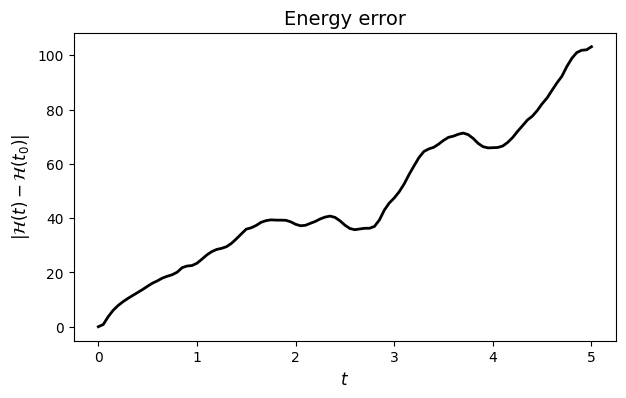

In [25]:
Hs = jax.vmap(H_energy)(sol.ys)

fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(sol.ts, jnp.abs(Hs-Hs[0]), 'k', linewidth=lw)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$|\mathcal{H}(t) - \mathcal{H}(t_0)|$', fontsize=12)
plt.title('Energy error', fontsize=14)
plt.show()

## Solve many KdVs at once!

In [18]:
num_samples = 8000

keys = random.split(random.PRNGKey(0), num_samples)

initial_conditions = jax.vmap(jax.vmap(initial_condition_kdv, [0, None]), [None, 0])(x, keys)

initial_conditions = initial_conditions[:, jnp.newaxis, :]